# Advanced business analytics - Exploratory notebook

Import packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from matplotlib import cm
from PIL import Image
import warnings
tqdm.pandas()
df = pd.read_csv("Data/articles_data.csv")

A quick overview of the data

In [2]:
df.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


### Basic exploration of the data

This data exploration will main revovle around the article data set, where each row represents an unique article. In the output below an overview of the columns and their data type can be seen. Most of the columns are rather self-explainatory. However, a few require further elaboration:
* "Content" - which only contains the first 250 characters in each article

* "top_article" - a binary column indicating if article was listed as a top article on publisher website

* "engagement_reaction_count" - Users reactions count for posts on Facebook involving article URL

* "engagement_comment_count" - Users comments count for posts on Facebook involving article URL

* "engagement_share_count" - Users shares count for posts on Facebook involving article URL

* "engagement_comment_plugin_count" - Users comments count for Facebook comment plugin on article website

We take a quick look at the data types, there are multiple categorical values, while all engagement metrics are in float.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10435 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          9145 non-null   object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

A further look into the data shows that there a missing values in most of the columns.

In [5]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])
#Code inspired from https://www.kaggle.com/code/kingabzpro/internet-news-and-consumer-engagement



,NA Count,NA Percent
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


However we have 10000 unique articles, so for the sake of having clean data data we are dropping the rows with missing NA values as well as the column "Unnamed" which is identical to the index

In [6]:
df = df.dropna(subset = [ 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'published_at',
       'top_article', 'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count', 'content'])

We will change the publishing date to date time for later:

In [29]:
warnings.filterwarnings("ignore")
df.published_at = pd.to_datetime(df.published_at)

df['Day_Of_Week'] = df.published_at.apply(lambda x: x.dayofweek)
df['Month'] = df.published_at.apply(lambda x: x.month)
df['Year'] = df.published_at.apply(lambda x: x.year)

Lets have a quick look at the number of articles published each day, here we can also see that our data spans from Start september to mid october, roughly 1.5 month which is that big a time interval.

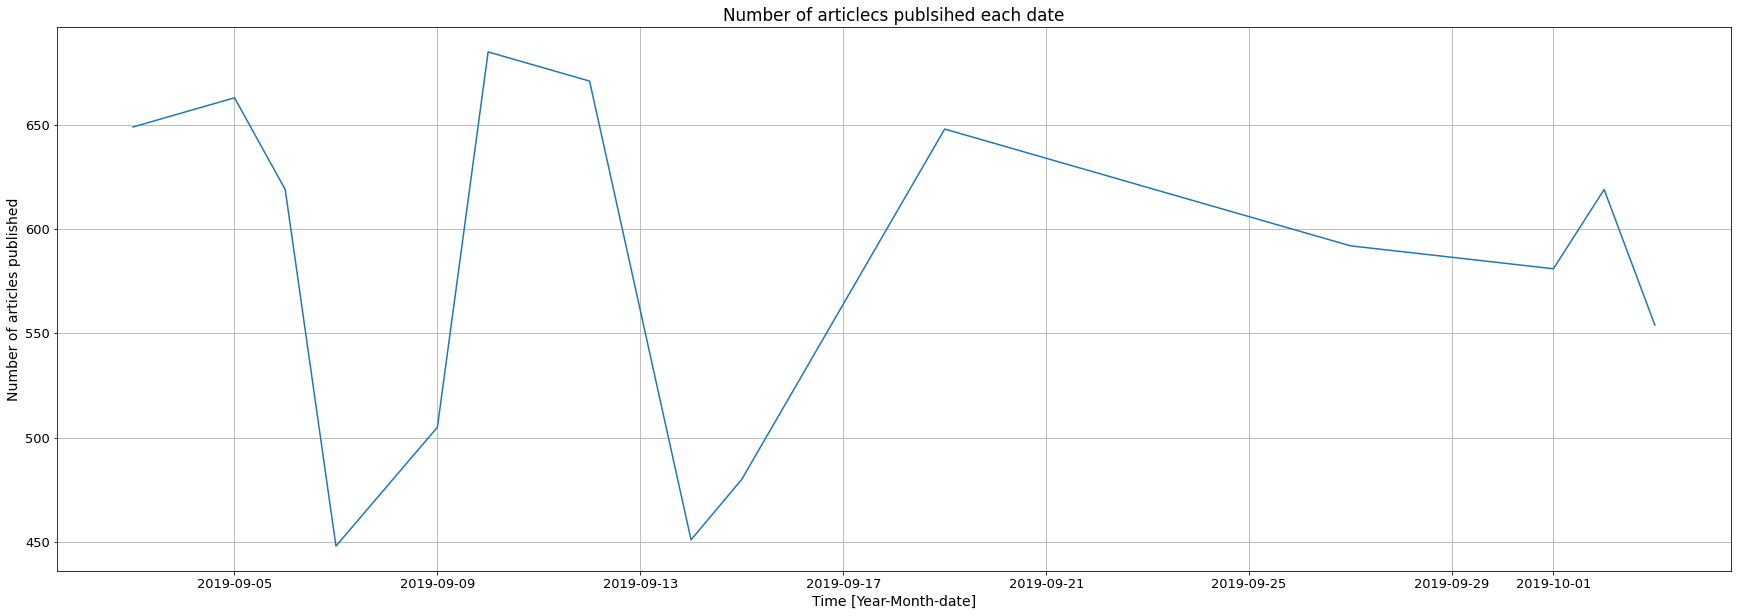

In [86]:
plt.rcParams.update({'font.size': 14})
df.published_at.dt.date.value_counts().plot(figsize=(30,10),
                                            xlabel="Time [Year-Month-date]",
                                            ylabel="Number of articles published",
                                            fontsize=13,
                                            title="Number of articlecs publsihed each date")
plt.grid()

Lets have a look if there is a trend for when articles are published (Local time). Here we can see a quite interesting pattern. As could be assummed very few articles are published at night 24:00 -> 06:00, it could be assummed that a lot of these stories are breaking news from around the world. Then a steady increase of articles published occurs between 06:00 -> 17:00. Intereting enough no articles in our data set is published between 19:00 -> 24:00, which seems very odd. We can see that only a small part of all the articles are top articles, which follows the same distribution as all the articlecs.

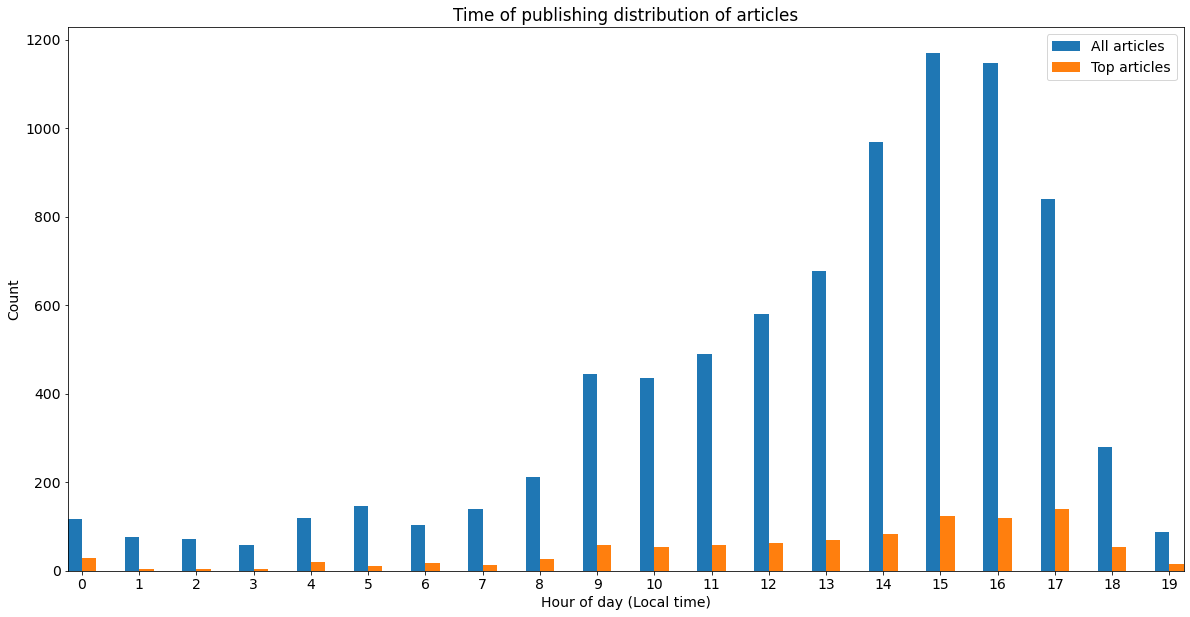

In [126]:
bar_df=df.published_at.dt.hour.value_counts().sort_index().to_frame()
bar_df['Top_article']=df.groupby(df["published_at"].dt.hour)['top_article'].sum().values

_, ax = plt.subplots()
bar_df.plot(
            kind="bar",
            figsize=(20,10),
            title="Time of publishing distribution of articles",
            xlabel="Hour of day (Local time)",
            ylabel="Count",
            rot=0,
            ax=ax,
            legend="Count of all articles");
bar_df.Top_article.plot(
            kind="bar",
            figsize=(20,10),
            title="Time of publishing distribution of articles",
            xlabel="Hour of day (Local time)",
            ylabel="Count",
            rot=0,
            ax=ax,
            color="orange",
            width=0);
ax.legend(["All articles", "Top articles"])

#df.groupby(df["published_at"].dt.hour)['top_article'].count().plot(kind="bar")
#seaborn.countplot(data=df, x='reputation', order=df.reputation.value_counts().index)

Lets explore the data further, here we take a look at the top 15 authors based on number of articles written, and the top Sources based on number of articles published. Its quite clear that the top "top" authors are not individual persons, but articles published in the name of the publisher. There are a few indivduals based on who have written an impressive amount of articles (40-80) in the 1.5 month interval our data spans over.

In [50]:
figure, ax = plt.subplots(2, 1,figsize=(20,15),dpi=1200)
plt.tight_layout

df['author'].value_counts()[:15].plot(kind='barh',
                                      title="Top 15 Authors"
                                      ,ax=ax[0],
                                      fontsize=13,
                                      xlabel="Count",
                                      ylabel="Author")

df['source_name'].value_counts().plot(kind='barh',
                                      title="Top Sources",
                                      ax=ax[1],
                                      fontsize=13,
                                      xlabel="Count",
                                      ylabel="Publisher")
plt.show()

Finally we have the Facebook metrics for the articles we can a deeper look into. Below is the four different metrics shown with a distribution plot with a (Log/Lin) axis. The first thing that can be seen is there are a lot more different values for the metrics showing "Reaction_count, Comment_count, share_count" compared to "comment_plugin_count_metric". Another intersting thing from the plot is that the majortiy of articles have all most no engangement, all graphs seems to be log normal distributed.

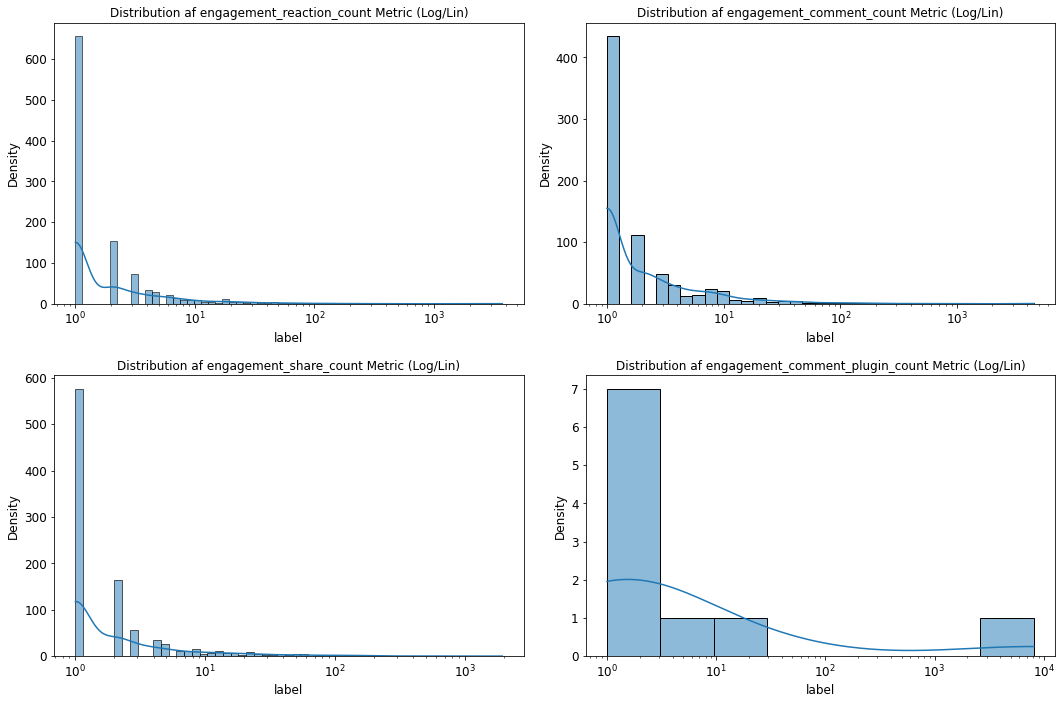

In [70]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
channels=['engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count']
k=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=12)
        ax[j][i].set_xlabel('label', fontsize=12, position=(.5,20))
        ax[j][i].set_ylabel('Density', fontsize=12)
        ax[j][i].set_title(f'Distribution af {channels[k]} Metric (Log/Lin)', size=12)
        ax[j][i].set(xscale="log")
        ax[j][i] = sns.histplot(df[channels[k]].value_counts(), ax=ax[j][i],kde=True, stat="density")
        k+=1

fig.tight_layout()
#plt.savefig("DistKanal.png")

Now that we have gone through the more interesting attributes in the data set, lets have a look how they correlate with eachother.

It can be that there are quite high correlation between all of the metrics but the "Engangement_comment_plug_in". We can also see that there is some correlation between the share_count and whether the article is a top one.

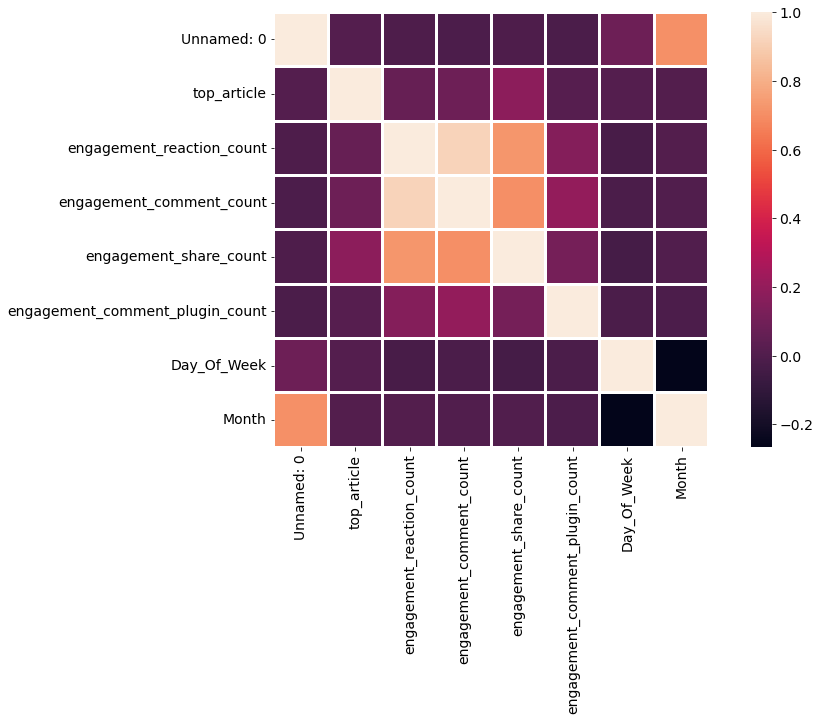

In [133]:
corr=df.drop(columns=["Year"]).corr()
plt.figure(figsize=(15,8))
ax1 = sns.heatmap(corr, linewidths=2, square=True, cmap='rocket')
plt.show()

# Scraping pictures

In our data set we also have a column containing URLS for the cover picture of every article. This could be quite interesting to use in our final prediction model. Therefore we will scarpe all the images we can get a hold of. Scraping pictures from specific URLS are different than pinging a website for different content. 

First we will do some data cleaning in the URLS. After some trial and error we saw specific URLS types which gave a bad respond but could modified.

In [ ]:
import re
front="/images/"
front2="/image/"
end="-"
Front_url="https://i.insider.com/"

new_urls=[]

for i in range(len(df)):
    if df.source_id.iloc[i]=="business-insider":
        try:
                if df.iloc[i].url_to_image[0:11]=="https://amp":
                    id_name=re.search(f'{front}(.*)', df.iloc[i].url_to_image.split("-")[0]).group(1)
                    full_url = Front_url+id_name
                    new_urls.append(full_url)

                else:
                    id_name=re.search(f'{front2}(.*)', df.iloc[i].url_to_image.split("-")[0]).group(1)
                    full_url = Front_url+id_name
                    new_urls.append(full_url)
        except:
            new_urls.append(df.iloc[i].url_to_image)
    else: new_urls.append(df.iloc[i].url_to_image)

We then save a list with All the new URLS and their index in the data frame.

In [ ]:
df['url_to_image_real']=new_urls
urls=[x for x in df.url_to_image_real]
index=[x for x in df.index]

This function will create a request to the given URL, save the picture as PNG. Then reopen the picture, resize it to a 128*128 shape and finally save it. 

In [ ]:
import time
def im_scrape(urls,filename):
    call = requests.get(urls)
    if str(call)=="<Response [200]>":
        img_data = call.content
        with open(f'images/{filename}.png', 'wb') as handler:
             handler.write(img_data)
        #time.sleep(2) 
        image=Image.open(f"images/{filename}.png")
        resized_image = image.resize((128,128))
        resized_image.save(f'images/{filename}.png')
        
    else:
        print(urls)

In [ ]:
for i in range(len(urls)):
    try:
        im_scrape(urls[i],index[i])
    except: #print all failing URLS
        print(urls[i])

https://www.irishtimes.com/image-creator/?id=1.4036177&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4036386&origw=1440
https://s.abcnews.com/images/Health/trump-autism-bill-ht-jt-191002_hpMain_16x9_992.jpg
https://a1.espncdn.com/combiner/i?img=%2Fmedia%2Fmotion%2F2019%2F1002%2Fdm_191002_gardner_minshew%2Fdm_191002_gardner_minshew.jpg
https://www.irishtimes.com/image-creator/?id=1.4037642&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4038725&origw=1058
https://www.irishtimes.com/image-creator/?id=1.4038841&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4038955&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4039311&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4039320&origw=1440


Since we plan on using our images for predictions, we will remove all articles where we did not get an image from. This leaves us with roughly 7500 articles.

In [127]:
from os import listdir
from os.path import isfile, join
mypath="/Users/martinillum/Desktop/Desktop_mac_air/Kandidat/Advanced_business_analytics/Final_project/ABA_2022/Data/images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
sorted_list = [x.split(".")[0] for x in onlyfiles]
sorted_list = sorted(sorted_list)[1:]
sorted_list = sorted([int(x) for x in sorted_list])
sorted_list = [str(x)+".png" for x in sorted_list]

In [9]:
df = df.loc[sorted_list_number]
df=df.rename(columns = {df.columns[0]:'Image_path'})
df.to_csv("Data/Final_data_cleaing.csv")